# This notebook is dedicated to the MLP model implementation with the optimization of the Research Project
### MSC/DSA/134

In [1]:
# import required packages
from globals.pandas_functions import *
import globals.hyperparameter_optimizer as hyp_optimizer
import globals.torch_gpu_processing as torch_gpu_processing
from sklearn.model_selection import train_test_split

In [2]:
# import datasets
# load preprocessed training and testing data
data_base_path = "data/processed/null_value_option_1_with_validation_set/scaled_and_balanced"


X_train = pd.read_csv(f"{data_base_path}/pca_selected_features/unified_transaction_data_option2_x_train_pca.csv")
X_validation = pd.read_csv(f"{data_base_path}/pca_selected_features/unified_transaction_data_option2_x_validation_pca.csv")
X_test = pd.read_csv(f"{data_base_path}/pca_selected_features/unified_transaction_data_option2_x_test_pca.csv")

y_train = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_y_train_balanced.csv")
y_validation = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_y_validation.csv")
y_test = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_y_test.csv")

In [2]:
# import datasets : without PCA
data_base_path = "data/processed/null_value_option_1_with_validation_set/scaled_and_balanced"


X_train = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_x_train_balanced.csv")
X_validation = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_x_validation_scaled.csv")
X_test = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_x_test_scaled.csv")

y_train = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_y_train_balanced.csv")
y_validation = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_y_validation.csv")
y_test = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_y_test.csv")

In [3]:
dataset_dimension("X_train", X_train)
dataset_dimension("X_validation", X_test)
dataset_dimension("X_test", X_test)

dataset_dimension("y_train", y_train)
dataset_dimension("y_validation", y_validation)
dataset_dimension("y_test", y_test)

X_train dataset dimension: (683822, 26)
X_validation dataset dimension: (118102, 26)
X_test dataset dimension: (118102, 26)
y_train dataset dimension: (683822, 1)
y_validation dataset dimension: (118102, 1)
y_test dataset dimension: (118102, 1)


In [6]:
torch_gpu_processing.shared_test_direct_ml_processing()

DirectML device: privateuseone:0
Test operation successful: [2. 4.]


True

## MLP Model Implementation with Hyperparameter Optimization

In [5]:
# set optimizer properties

param_optimizer_algorithm = "PSO"   # "PSO", "GWO", "FA"
population = 15     # number of candidate solutions
iterations = 5     # optimization iterations (epochs in mealpy terms)
epochs_for_evaluation = 10  # Increased from 6 to ensure models converge during optimization
batch_size = 1024
early_stopping = 4
seed = 42

# Layer bounds settings
min_hidden_layers = 1
max_hidden_layers = 10

sample_size = 60000  # Increased from 25000 for better representation during optimization

In [6]:
# Stratified sampling to maintain class balance
def get_stratified_sample(X, y, sample_size, random_state=42):
    """
    Get a stratified sample maintaining class balance.

    Parameters:
    -----------
    X : array-like
        Features
    y : array-like
        Labels
    sample_size : int
        Desired sample size
    random_state : int
        Random seed for reproducibility

    Returns:
    --------
    X_sample, y_sample : tuple
        Stratified sample of features and labels
    """
    if sample_size >= len(X):
        print(f"Sample size ({sample_size}) >= dataset size ({len(X)}). Using full dataset.")
        return X, y

    # Use stratified sampling to maintain class balance
    X_sample, _, y_sample, _ = train_test_split(
        X, y,
        train_size=sample_size,
        stratify=y,
        random_state=random_state
    )
    return X_sample, y_sample

# Get balanced sample for optimization
print(f"Full training set size: {len(X_train)}")
print(f"Creating stratified sample of size: {sample_size}")

X_train_sample, y_train_sample = get_stratified_sample(
    X_train.to_numpy(),
    y_train.to_numpy().ravel(),
    sample_size=sample_size,
    random_state=seed
)

Full training set size: 683822
Creating stratified sample of size: 60000


In [ ]:
# NOTE: Using stratified sampling from Cell 8 instead of random sampling
# This ensures class balance is maintained during optimization
# Random sampling code removed - using get_stratified_sample from Cell 8

In [7]:
def show_class_distribution(x_df, y_df):
    print(f"\nSample created for optimization:")
    print(f"  Total samples: {len(x_df)}")
    print(f"  Y df samples: ", y_df)
    print(f"  Class 0 (non-fraud): {(y_df == 0).sum()} ({(y_df == 0).sum() / len(y_df) * 100:.2f}%)")
    print(f"  Class 1 (fraud): {(y_df == 1).sum()} ({(y_df == 1).sum() / len(y_df) * 100:.2f}%)")


show_class_distribution(X_train_sample, y_train_sample)
# show_class_distribution(X_validation, y_validation.to_numpy().ravel())


Sample created for optimization:
  Total samples: 60000
  Y df samples:  [1 0 1 ... 0 1 0]
  Class 0 (non-fraud): 30000 (50.00%)
  Class 1 (fraud): 30000 (50.00%)


In [8]:
 # execute hyperparameter optimization
optimizer_algorithm = param_optimizer_algorithm   # "PSO", "GWO", "FA" (Firefly)
optimizer_objective = torch_gpu_processing.mlp_set_optimizer_objective(
    X_train_sample,
    y_train_sample,
    X_validation,
    y_validation,
    max_epochs=epochs_for_evaluation,
    batch_size=batch_size,
    seed=seed,
    early_stopping_patience=early_stopping
)

print(f"\nRunning optimizer: {optimizer_algorithm} (pop={population}, iters={iterations})")
print(f"Optimizing Hidden Layers between {min_hidden_layers} and {max_hidden_layers}")

best_vector, best_objective, best_hyper_params, epoch_logs = hyp_optimizer.mlp_run_hyperparam_optimization(
    optimizer_algorithm,
    optimizer_objective,
    iterations=iterations,
    population=population,
    min_layers=min_hidden_layers,
    max_layers=max_hidden_layers
)
print("\nBest objective (1 - F1):", best_objective)
print("Best F1:", 1.0 - best_objective)
print("Best hyperparameters:", best_hyper_params)


Optimizer using device: privateuseone:0

Data Distribution Check:
  Training fraud rate: 0.5000 (should be ~0.50 after SMOTE)
  Validation fraud rate: 0.0350 (should be original imbalanced)

Intelligent validation downsampling (preserving ALL fraud)...
  Original validation size: 118102
  Fraud samples: 4131
  Normal samples: 113971
  Downsampled validation size: 10000
  - Fraud samples: 4131 (100% retention)
  - Normal samples: 5869 (5.1% retention)

Final validation fraud rate: 0.4131
Final validation size: 10000

Class weight calculation:
  Positive samples: 30000
  Negative samples: 30000
  Positive class weight: 1.0000 (should be ~1.0 after SMOTE)

Running optimizer: PSO (pop=15, iters=5)
Optimizing Hidden Layers between 1 and 10
.......... 68.0s | Train F1: 0.7784 Acc: 0.7733 | Val F1: 0.7107 Acc: 0.7548 AUPRC: 0.8105].......... 445.4s | Train F1: 0.7622 Acc: 0.7644 | Val F1: 0.7012 Acc: 0.7613 AUPRC: 0.8049].......... 81.7s | Train F1: 0.7384 Acc: 0.7395 | Val F1: 0.6839 Acc: 0.

In [5]:
best_hyper_params =  {'n_layers': 7, 'units_per_layer': [576, 384, 224, 384, 560, 208, 928], 'activations': ['elu', 'elu', 'gelu', 'relu', 'leaky_relu', 'silu', 'leaky_relu'], 'legacy_activation': 'elu', 'legacy_batch_norm': False, 'legacy_dropout_rate': 0.013911119719586862}

# TODO: test with this hyperparam set

In [7]:
print("\nRetraining best model on full training set...")
print("Using validation set for early stopping, test set for final evaluation only.")
model, test_metrics = torch_gpu_processing.mlp_train_final_model(
    best_hyper_params, 
    X_train.to_numpy(), 
    y_train.to_numpy().ravel(), 
    X_validation.to_numpy(),  # Validation set for early stopping
    y_validation.to_numpy().ravel(), 
    X_test.to_numpy(),  # Test set for final evaluation only
    y_test.to_numpy().ravel(), 
    batch_size
)
print("\nFinal Test Set Metrics:")
print("=" * 60)
print("Primary Metrics (Optimal Threshold - matches optimization):")
print(f"  Optimal F1:       {test_metrics.get('optimal_f1', 'N/A'):.4f}")
print(f"  Optimal Precision: {test_metrics.get('optimal_precision', 'N/A'):.4f}")
print(f"  Optimal Recall:    {test_metrics.get('optimal_recall', 'N/A'):.4f}")
print(f"  Optimal Threshold: {test_metrics.get('optimal_threshold', 'N/A'):.4f}")
print("\nReference Metrics (Threshold 0.5):")
print(f"  F1 @ 0.5:        {test_metrics.get('threshold_05_f1', 'N/A'):.4f}")
print(f"  Precision @ 0.5: {test_metrics.get('threshold_05_precision', 'N/A'):.4f}")
print(f"  Recall @ 0.5:    {test_metrics.get('threshold_05_recall', 'N/A'):.4f}")


Retraining best model on full training set...
Using validation set for early stopping, test set for final evaluation only.
FINAL MODEL TRAINING
Hyperparameters: {'n_layers': 7, 'units_per_layer': [576, 384, 224, 384, 560, 208, 928], 'activations': ['elu', 'elu', 'gelu', 'relu', 'leaky_relu', 'silu', 'leaky_relu'], 'legacy_activation': 'elu', 'legacy_batch_norm': False, 'legacy_dropout_rate': 0.013911119719586862}
Training on device: privateuseone:0
Using positive class weight: 1.0000

Starting training for 50 epochs...
Epoch 1/50: Train Loss=0.4833, Val Loss=0.3715 (New Best)
Epoch 6/50: Train Loss=0.2233, Val Loss=0.2308 (New Best)
Epoch 11/50: Train Loss=0.1606, Val Loss=0.2278
Epoch 16/50: Train Loss=0.1299, Val Loss=0.1962 (New Best)
Epoch 21/50: Train Loss=0.1114, Val Loss=0.2065
Epoch 26/50: Train Loss=0.0983, Val Loss=0.2185
Epoch 31/50: Train Loss=0.0880, Val Loss=0.2203
Epoch 36/50: Train Loss=0.0818, Val Loss=0.1980
Early stopping triggered at epoch 39.
Restored best model w

In [ ]:
# TODO: export the best model

In [ ]:
# below shows an example of tf based training output with no result

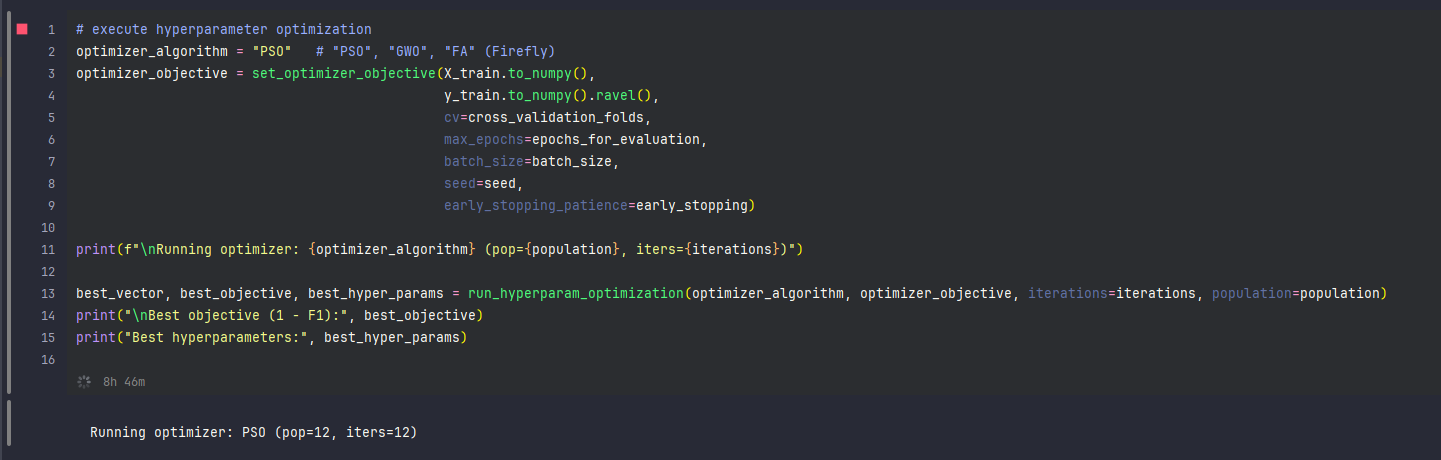

In [ ]:
# gpu crashed during the training after 21 hours

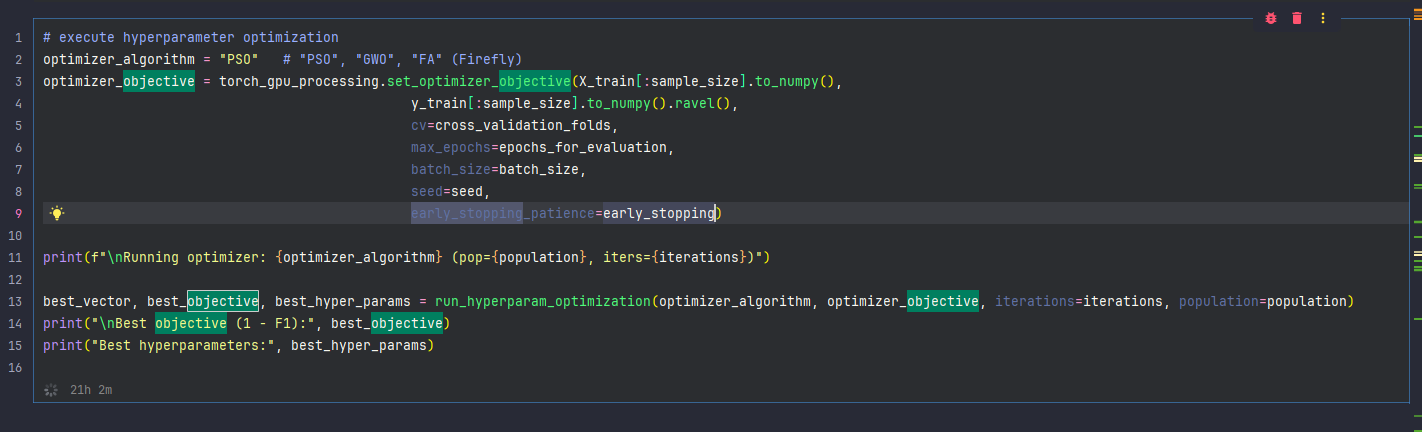